## notebook setup
### Import Libraries

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import pandas as pd


### Define Paths


In [7]:
# Paths to the dataset directories
base_dir = "../../data/medical_images/"
train_dir = os.path.join(base_dir, "train/")
val_dir = os.path.join(base_dir, "val/")
test_dir = os.path.join(base_dir, "test/")

In [8]:

for directory in [test_dir, train_dir, val_dir]:
    if not os.path.exists(directory):
        raise FileNotFoundError(f"{directory} not found. Make sure data preparation is complete.")

## Data Preprocessing
### ImageDataGenerator for the training set

In [9]:
# Image dimensions and batch size
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,          # Normalize pixel values to [0, 1]
    rotation_range=20,        # Rotate images by up to 20 degrees
    width_shift_range=0.2,    # Horizontal shift
    height_shift_range=0.2,   # Vertical shift
    shear_range=0.2,          # Shearing transformation
    zoom_range=0.2,           # Zoom in/out
    horizontal_flip=True,     # Random horizontal flips
    fill_mode='nearest'       # Fill in missing pixels
)

# Validation and testing data generators
val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 4094 images belonging to 2 classes.
Found 469 images belonging to 2 classes.
Found 1160 images belonging to 2 classes.


## Build Two Neural Network Architectures
### 1. CNN with Batch Normalization and Dropout

In [10]:
def build_simple_cnn(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Build model
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
num_classes = len(train_generator.class_indices)
model1 = build_simple_cnn(input_shape, num_classes)
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model1.summary()


c:\Users\saif\source\ai_project\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,907,650 (91.20 MB)

 Trainable params: 23,907,650 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

### 2. Deeper CNN with Batch Normalization

In [11]:
def build_deep_cnn(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Build model
model2 = build_deep_cnn(input_shape, num_classes)
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,246,082 (84.86 MB)

 Trainable params: 22,245,634 (84.86 MB)

 Non-trainable params: 448 (1.75 KB)

## Train the models
### define callbacks

In [14]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint1 = ModelCheckpoint('../../models/medical_image_classification/model1.keras', save_best_only=True, monitor='val_loss')
checkpoint2 = ModelCheckpoint('../../models/medical_image_classification/model2.keras', save_best_only=True, monitor='val_loss')


### train model1

In [32]:
# Check if checkpoint exists and load if it does
checkpoint_path = '../../models/medical_image_classification/model1.keras'
if os.path.exists(checkpoint_path):
    model1 = tf.keras.models.load_model(checkpoint_path)
    print("Loaded existing model from checkpoint")

# Train the model
history1 = model1.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, checkpoint1]
)

Loaded existing model from checkpoint
Epoch 1/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 100s 774ms/step - accuracy: 0.8095 - loss: 0.4567 - val_accuracy: 0.8081 - val_loss: 0.4510
Epoch 2/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 103s 800ms/step - accuracy: 0.7978 - loss: 0.4648 - val_accuracy: 0.8422 - val_loss: 0.4226
Epoch 3/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.8025 - loss: 0.4573 - val_accuracy: 0.8124 - val_loss: 0.4544
Epoch 4/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 124s 860ms/step - accuracy: 0.8243 - loss: 0.4381 - val_accuracy: 0.8230 - val_loss: 0.4292
Epoch 5/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 95s 744ms/step - accuracy: 0.8150 - loss: 0.4441 - val_accuracy: 0.8273 - val_loss: 0.4228
Epoch 6/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 98s 762ms/step - accuracy: 0.8201 - loss: 0.4389 - val_accuracy: 0.8294 - val_loss: 0.4390
Epoch 7/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 83s 649ms/step - accuracy: 0.8196 - loss: 0.4492 - val_accuracy: 0.8038 - val_loss: 0.4673


In [21]:
# Check if checkpoint exists and load if it does
checkpoint_path = '../../models/medical_image_classification/model2.keras'
if os.path.exists(checkpoint_path):
    model2 = tf.keras.models.load_model(checkpoint_path)
    print("Loaded existing model from checkpoint")

history2 = model2.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, checkpoint2]
)


Epoch 1/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.6993 - loss: 4.6471 - val_accuracy: 0.2814 - val_loss: 11.3310
Epoch 2/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.7704 - loss: 0.5707 - val_accuracy: 0.7292 - val_loss: 3.2969
Epoch 3/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.7778 - loss: 0.5756 - val_accuracy: 0.6866 - val_loss: 1.5876
Epoch 4/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.7704 - loss: 0.5444 - val_accuracy: 0.7292 - val_loss: 0.5346
Epoch 5/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.7849 - loss: 0.5318 - val_accuracy: 0.7356 - val_loss: 0.5821
Epoch 6/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 125s 973ms/step - accuracy: 0.7762 - loss: 0.5284 - val_accuracy: 0.6354 - val_loss: 0.6530
Epoch 7/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 127s 988ms/step - accuracy: 0.7867 - loss: 0.5027 - val_accuracy: 0.8507 - val_loss: 0.4897
Epoch 8/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 122s 955ms/step - accuracy: 0.7879 - loss: 0.5115 

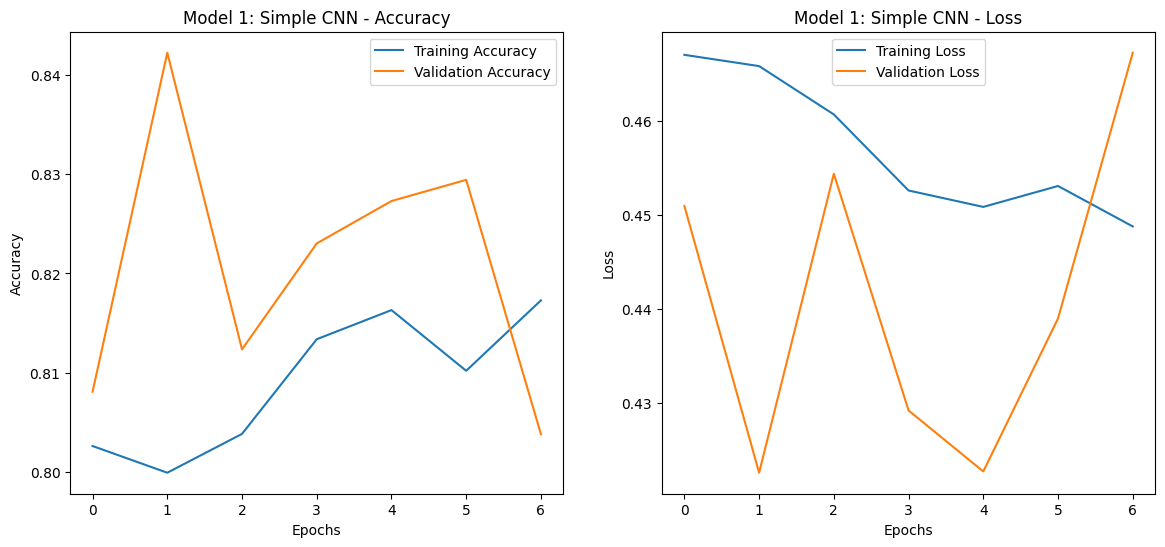

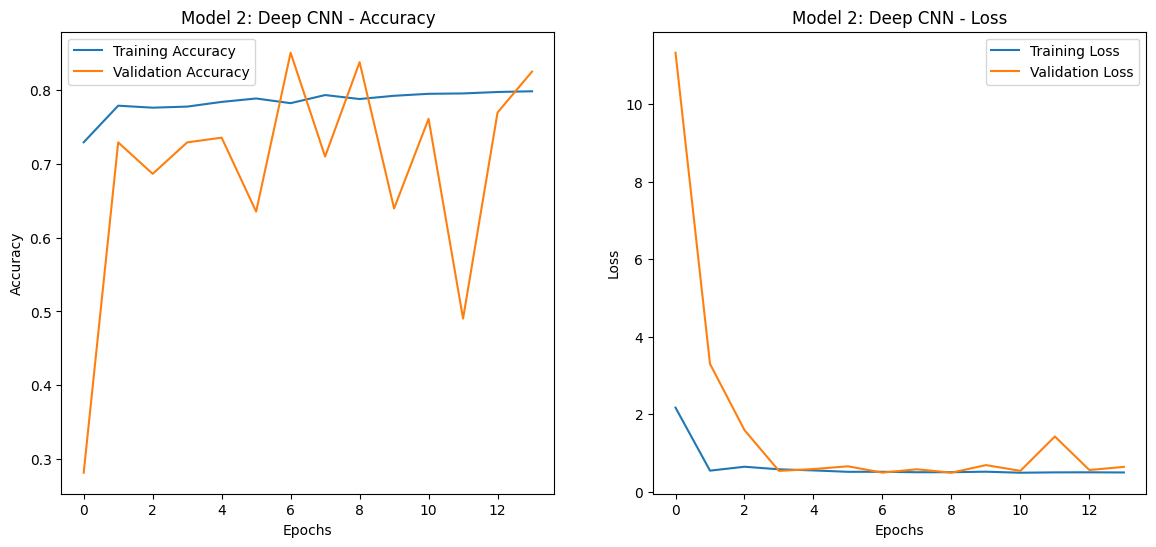

In [33]:
def plot_training_metrics(history, title):
    # Plot accuracy and loss over epochs
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title(f'{title} - Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # Loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title(f'{title} - Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.show()

# Plot metrics for both models
plot_training_metrics(history1, "Model 1: Simple CNN")
plot_training_metrics(history2, "Model 2: Deep CNN")


In [35]:
# Save class indices mapping
import json
class_indices_path = os.path.join("../../models/medical_image_classification", "class_indices.json")
with open(class_indices_path, 'w') as f:
    json.dump(train_generator.class_indices, f)

print("Class indices saved:", train_generator.class_indices)


Class indices saved: {'0': 0, '1': 1}


**Summary:**
- Trained two different CNN architectures:
  - Model 1: Simple CNN with fewer layers.
  - Model 2: Deep CNN with batch normalization.
- Early stopping and checkpoints were used to save the best-performing models.
- Training and validation metrics were plotted to visualize performance.

**Next Steps:**
- Proceed to `4_model_evaluation.ipynb` to evaluate the models on the test set and compare their performance.
